In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [4]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
previous_file_idx = -1
TOTAL_NUM_DAYS = len(daydic)

# Eularian Methods

In [5]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    
    def within_search_width(i_offset, j_offset):
        return distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                        lat_rho[i_search + i_offset, j_search + j_offset], 
                        lon_rho[i_search + i_offset, j_search + j_offset]) < SEARCH_WIDTH / 2

    i_left, i_right = 0, 0
    j_down, j_up = 0, 0

    while i_search - i_left >= 0 and within_search_width(-i_left, 0):
        i_left += 1
    while i_search + i_right < lon_rho.shape[0] and within_search_width(i_right, 0):
        i_right += 1
    while j_search - j_down >= 0 and within_search_width(0, -j_down):
        j_down += 1
    while j_search + j_up < lon_rho.shape[1] and within_search_width(0, j_up):
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_down = max(j_search - j_down + 1, 0)
    j_up = min(j_search + j_up, lon_rho.shape[1])

    return i_left, i_right, j_down, j_up

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def find_global_maxima(matrix):
    i_max, j_max = np.unravel_index(np.argmax(matrix, axis=None), matrix.shape)
    return i_max, j_max

def find_local_maxima(matrix):
    def is_local_maxima(matrix, i, j):
        rows, cols = matrix.shape
        value = matrix[i, j]
        if np.isnan(value):
            return False
        def is_valid_and_greater_than(value, neighbor):
            return not np.isnan(neighbor) and neighbor > value
        if i > 0 and is_valid_and_greater_than(value, matrix[i - 1, j]):
            return False
        if i < rows - 1 and is_valid_and_greater_than(value, matrix[i + 1, j]):
            return False
        if j > 0 and is_valid_and_greater_than(value, matrix[i, j - 1]):
            return False
        if j < cols - 1 and is_valid_and_greater_than(value, matrix[i, j + 1]):
            return False
        if i > 0 and j > 0 and is_valid_and_greater_than(value, matrix[i - 1, j - 1]):
            return False
        if i > 0 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i - 1, j + 1]):
            return False
        if i < rows - 1 and j > 0 and is_valid_and_greater_than(value, matrix[i + 1, j - 1]):
            return False
        if i < rows - 1 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i + 1, j + 1]):
            return False
        return True
    i_max, j_max, value_max = [], [], []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if is_local_maxima(matrix, i, j):
                i_max.append(i)
                j_max.append(j)
                value_max.append(matrix[i, j])
    return i_max, j_max, value_max

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def get_variable_name(var):
    for name, value in globals().items():
        if value is var:
            return name
    return None

def make_cartesian(lon, lat, theta0, phi0):
    lonr = np.deg2rad(lon)
    latr = np.deg2rad(lat)
    r_earth = 6371
    x = r_earth * np.cos(phi0) * (lonr - theta0)
    y = r_earth * (latr - phi0)
    return x, y

def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x/1000, y/1000

def rotate_30_clockwise(x, y):
    theta = np.deg2rad(30)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated, y_rotated

def extract_contour(level_to_extract, plot):
    for level_paths in plot.allsegs:
        for path in level_paths:
            xt = path[:, 0]
            yt = path[:, 1]
            return xt, yt
    else:
        return [], []

### Load Eddy Data

In [6]:
edata = eddies['Eddy22'].iloc[5] #E22T5
t = extract_number(edata.name)

mcolor = 'r' if edata.Vort > 0 else 'c'
colormap = 'Reds' if edata.Vort > 0 else 'Blues'

temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

t_mod = t % 30
file_idx = np.floor(t/30)
if file_idx != previous_file_idx:
    
    fnumber = '0'+str(round(1461+ file_idx*30))
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_'+fnumber+'.nc'
    dataset = nc.Dataset(fname)
    
    U = np.load('/srv/scratch/z5297792/Climatology/u_v/u_'+fnumber+'.npy')
    V = np.load('/srv/scratch/z5297792/Climatology/u_v/v_'+fnumber+'.npy')
    Vorticity = np.load('/srv/scratch/z5297792/Climatology/vorts/vort_'+fnumber+'.npy')
    TemperatureAnomaly = np.load('/srv/scratch/z5297792/Climatology/temps/temp_'+fnumber+'.npy') - np.repeat(temp_ave[:, :, :, np.newaxis], 30, axis=3)
    CurSpeed = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/cur_speed_'+fnumber+'.npy')
    CurSpeedAnomaly = CurSpeed - np.repeat(CurSpeed_ave[:, :, :, np.newaxis], 30, axis=3)
    OW = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/ow_'+fnumber+'.npy')
    ocean_time = dataset.variables['ocean_time'][:]
    
    previous_file_idx = file_idx

## Pin Point Methods

### 1. Extrema Method

#### Choose DataField

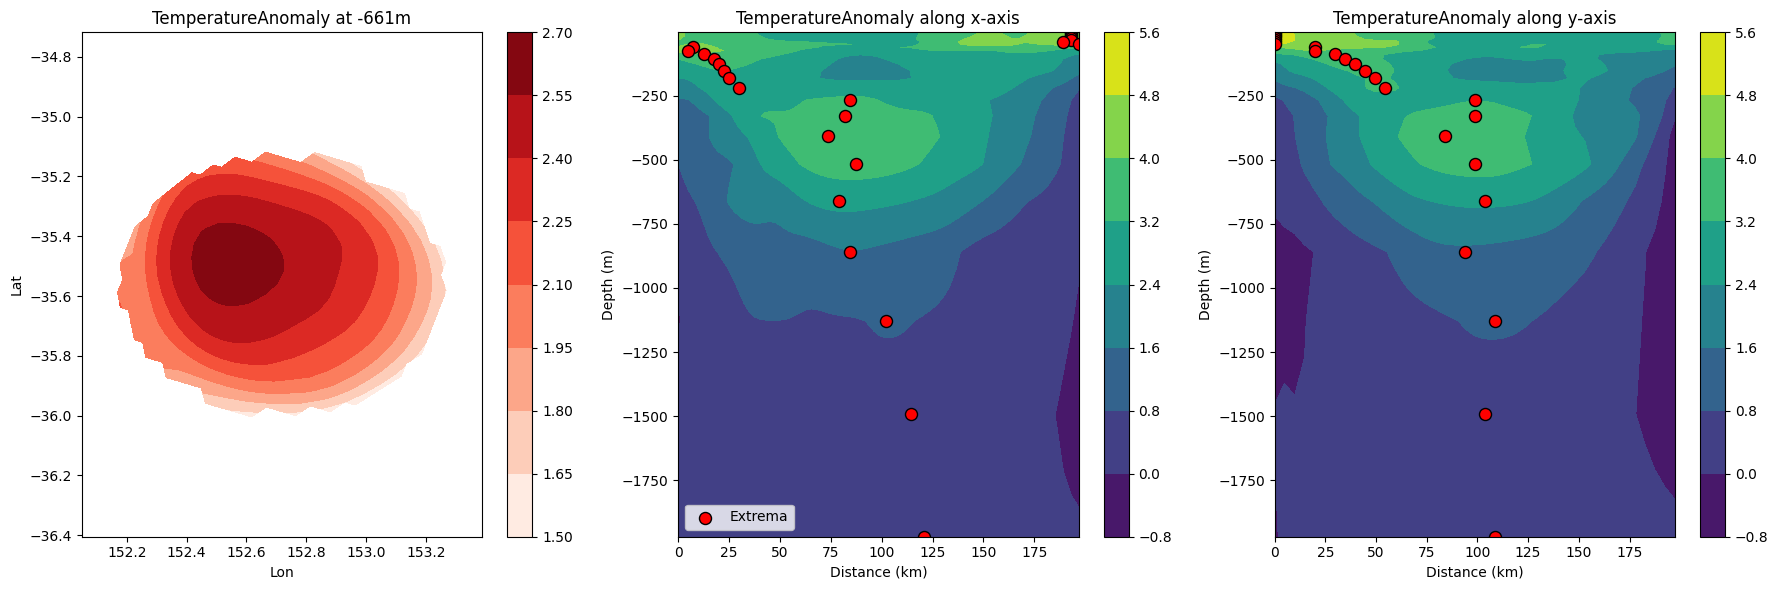

In [36]:
DataField1 = TemperatureAnomaly

DataField1_name = get_variable_name(DataField1)
DataField1 = np.squeeze(DataField1[:, :, :, t_mod])

# Create a figure with 1x3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

SEARCH_WIDTH = 200000
i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
depth_lvl_limit = 25
i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)
x = distance(lat_rho[i_left, j_search], lon_rho[i_left, j_search], lat_rho[i_left:i_right, j_search], lon_rho[i_left:i_right, j_search]) / 1000
y = distance(lat_rho[i_search, j_down], lon_rho[i_search, j_down], lat_rho[i_search, j_down:j_up], lon_rho[i_search, j_down:j_up]) / 1000
z = z_r[150, 150, :depth_lvl_limit]

# Plot 1: 
DEPTH_LVL = 20
R = distance(edata.Lat, edata.Lon, lat_rho, lon_rho)
mask = R < 50000  # m
DataField1_masked = np.where(mask, DataField1[:, :, DEPTH_LVL], np.nan)
c1 = axs[0].contourf(lon_rho, lat_rho, DataField1_masked, cmap=colormap)
fig.colorbar(c1, ax=axs[0])
axs[0].set_xlabel('Lon')
axs[0].set_ylabel('Lat')
axs[0].set_title(DataField1_name + ' at ' + str(round(z_r[150, 150, DEPTH_LVL])) + 'm')
axs[0].axis('equal')
axs[0].set_xlim([np.nanmin(np.where(mask, lon_rho, np.nan)) - 0.05, np.nanmax(np.where(mask, lon_rho, np.nan)) + 0.05])
axs[0].set_ylim([np.nanmin(np.where(mask, lat_rho, np.nan)) - 0.05, np.nanmax(np.where(mask, lat_rho, np.nan)) + 0.05])

# Plot 2: DataField1 cross-section along x-axis
DataField1_cross = DataField1[i_left:i_right, j_search, :depth_lvl_limit]
X, Z = np.meshgrid(x, z)
c2 = axs[1].contourf(X, Z, DataField1_cross.T)
fig.colorbar(c2, ax=axs[1])
axs[1].set_xlabel('Distance (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title(DataField1_name + ' along x-axis')
max_indices = np.nanargmax(DataField1_cross, axis=0) if edata.Vort > 0 else np.nanargmin(DataField1_cross, axis=0)
for r, max_index in enumerate(max_indices):
    m1 = axs[1].scatter(x[max_index], z[r], color=mcolor, edgecolor='k', s=75)
axs[1].legend([m1], ['Extrema'])

# Plot 3: DataField1 cross-section along y-axis
DataField1_cross = DataField1[i_search, j_down:j_up, :depth_lvl_limit]
Y, Z = np.meshgrid(y, z)
c3 = axs[2].contourf(Y, Z, DataField1_cross.T)
fig.colorbar(c3, ax=axs[2])
axs[2].set_xlabel('Distance (km)')
axs[2].set_ylabel('Depth (m)')
axs[2].set_title(DataField1_name + ' along y-axis')
max_indices = np.nanargmax(DataField1_cross, axis=0) if edata.Vort > 0 else np.nanargmin(DataField1_cross, axis=0)
for r, max_index in enumerate(max_indices):
    axs[2].scatter(y[max_index], z[r], color=mcolor, edgecolor='k', s=75)

plt.tight_layout()
plt.show()


#### 3D Application

In [9]:
SEARCH_RADIUS = 50000
DEPTH_LVL_LIMIT = 25

depth_dics1 = {}

clon, clat = edata.Lon, edata.Lat
for depth_lvl in range(DEPTH_LVL_LIMIT):

    i_search_lvl, j_search_lvl = eddies_nearest_rho(clon, clat)
    R = distance(lat_rho[i_search_lvl, j_search_lvl], lon_rho[i_search_lvl, j_search_lvl], lat_rho, lon_rho)
    mask = R < SEARCH_RADIUS
    
    DataField1_masked = np.where(mask, DataField1[:,:,depth_lvl], np.nan) 
    if np.any(np.isfinite(DataField1_masked)):
        if edata.Vort > 0:
            ic, jc = np.unravel_index(np.nanargmax(DataField1_masked), DataField1_masked.shape)
        elif edata.Vort < 0:
            ic, jc = np.unravel_index(np.nanargmin(DataField1_masked), DataField1_masked.shape)
        ic, jc = int(ic), int(jc)
    
        ix, jy = np.where(mask == True)
        df = pd.DataFrame({
            'i': ix,
            'j': jy,
            'DataField': DataField1_masked[ix,jy]
        })
    
        depth = float(z_r[150,150,depth_lvl])
    
        depth_dics1['Depth'+str(depth_lvl)] = {'df': df, 'ic': ic, 'jc': jc, 'Depth': depth}
    
        clon, clat = lon_rho[ic, jc], lat_rho[ic, jc]

# Calculate Cartesian Grid
theta0, phi0 = np.deg2rad(edata.Lon), np.deg2rad(edata.Lat)
for depth_dic in depth_dics1.values():
    
    ix = depth_dic['df'].i
    jy = depth_dic['df'].j
    ic = depth_dic['ic']
    jc = depth_dic['jc']
    
    lons, lats = lon_rho[ix, jy], lat_rho[ix, jy]
    lonc, latc = lon_rho[ic, jc], lat_rho[ic, jc]

    x, y = make_cartesian(lons, lats, theta0, phi0)
    xc, yc = make_cartesian(lonc, latc, theta0, phi0)

    depth_dic['df']['x'] = x
    depth_dic['df']['y'] = y
    depth_dic['xc'] = float(xc)
    depth_dic['yc'] = float(yc)

#### Results

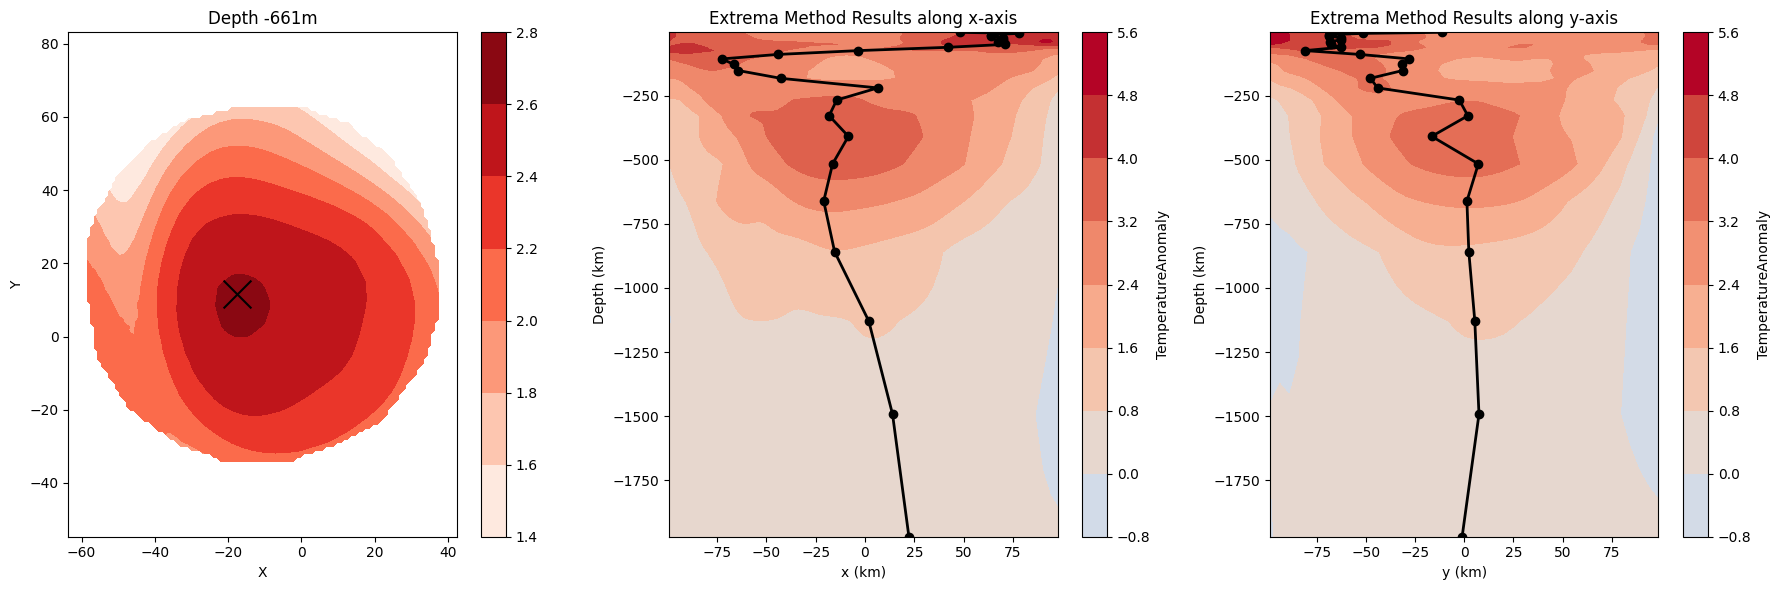

In [35]:
from scipy.interpolate import griddata

DEPTH_LVL_LIMIT = 25

# Create the 1x3 subplot figure
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Subplot 1
depth_dic = depth_dics1['Depth20']
DF = depth_dic['df']['DataField']
x = depth_dic['df'].x
y = depth_dic['df'].y
xc = depth_dic['xc']
yc = depth_dic['yc']
X, Y = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
Z = griddata((x, y), DF, (X, Y), method='linear')

pc = axs[0].contourf(X, Y, Z, cmap=colormap)
fig.colorbar(pc, ax=axs[0])
axs[0].scatter(xc, yc, marker='x', color='k', s=400)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_title('Depth '+str(round(depth_dic['Depth']))+'m')
axs[0].axis('equal')

# For the 2nd and 3rd subplots
import matplotlib.colors as mcolors

DISPLAY_WIDTH = 200000

i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, DISPLAY_WIDTH)
x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)
xc_raw, yc_raw, zc = [], [], []
for depth_dic in depth_dics1.values():
    xc_raw.append(depth_dic['xc'])
    yc_raw.append(depth_dic['yc'])
    zc.append(depth_dic['Depth'])
xc, yc = rotate_30_clockwise(xc_raw, yc_raw)
z = z_r[150, 150, :DEPTH_LVL_LIMIT]

# 2nd subplot
DataField1_cross = DataField1[i_left:i_right, j_search, :DEPTH_LVL_LIMIT]
X, Z = np.meshgrid(x, z)
DataField1_data_range = np.nanmax(np.abs(DataField1_cross))
c1 = axs[1].contourf(X, Z, DataField1_cross.T, cmap='coolwarm', vmin=-DataField1_data_range, vmax=DataField1_data_range)
axs[1].set_xlabel('x (km)')
axs[1].set_ylabel('Depth (km)')
axs[1].set_title('Extrema Method Results along x-axis')
fig.colorbar(c1, ax=axs[1], label=DataField1_name)
axs[1].plot(xc, zc, color='k', linewidth=2)
axs[1].scatter(xc, zc, color='k')

# 3rd subplot
DataField1_cross = DataField1[i_search, j_down:j_up, :DEPTH_LVL_LIMIT] 
Y, Z = np.meshgrid(y, z)
DataField1_data_range = np.nanmax(np.abs(DataField1_cross))
c2 = axs[2].contourf(Y, Z, DataField1_cross.T, cmap='coolwarm', vmin=-DataField1_data_range, vmax=DataField1_data_range)
axs[2].set_xlabel('y (km)')
axs[2].set_ylabel('Depth (km)')
axs[2].set_title('Extrema Method Results along y-axis')
fig.colorbar(c2, ax=axs[2], label=DataField1_name)
axs[2].scatter(yc, zc, color='k')
axs[2].plot(yc, zc, color='k', linewidth=2)

plt.tight_layout()
plt.show()


### 2. COW Method

In [13]:
SEARCH_RADIUS_MAX = 50000
CURSPEED_THRESH = 0.05
OW_THRESH = -2e-11
RATIO_THRESH = 2/3
DEPTH_LVL_LIMIT = 25

theta0, phi0 = np.deg2rad(edata.Lon), np.deg2rad(edata.Lat)

depth_dics2 = {}
clon, clat = edata.Lon, edata.Lat
for depth_lvl in range(DEPTH_LVL_LIMIT):

    Search_Radius = 5000
    while Search_Radius <= SEARCH_RADIUS_MAX:

        R = distance(clat, clon, lat_rho, lon_rho)
        mask = R < Search_Radius
    
        cur_speed_masked = np.where(mask, CurSpeed[:,:,depth_lvl, t_mod], np.nan) 
        ow_masked = np.where(mask, OW[:,:,depth_lvl, t_mod], np.nan) 
    
        pot_i, pot_j = np.where((cur_speed_masked < CURSPEED_THRESH) & (ow_masked < OW_THRESH))
        ratio = len(pot_i) / np.sum(mask) if len(pot_i) != 0 else 0
            
        if ratio <= RATIO_THRESH and ratio != 0:
            X = np.array([lon_rho[pot_i, pot_j], lat_rho[pot_i, pot_j]])
            clon, clat = np.mean(X, axis=1)
            plon, plat = lon_rho[pot_i, pot_j], lat_rho[pot_i, pot_j]

            xc, yc = make_cartesian(clon, clat, theta0, phi0)
            x, y = make_cartesian(plon, plat, theta0, phi0)

            df = pd.DataFrame({
                'Pot i': pot_j,
                'Pot j': pot_j,
                'x': x,
                'y': y,
                'OW': ow_masked[pot_i, pot_j],
                'CurSpeed': cur_speed_masked[pot_i, pot_j]
            })
            
            depth_dics2[f'Depth{depth_lvl}'] = {
                'df': df, 
                'xc': xc, 
                'yc': yc, 
                'Search Radius': Search_Radius, 
                'Depth': z_r[150, 150, depth_lvl]
            }
            break  
                        
        Search_Radius += 5000

#### Results

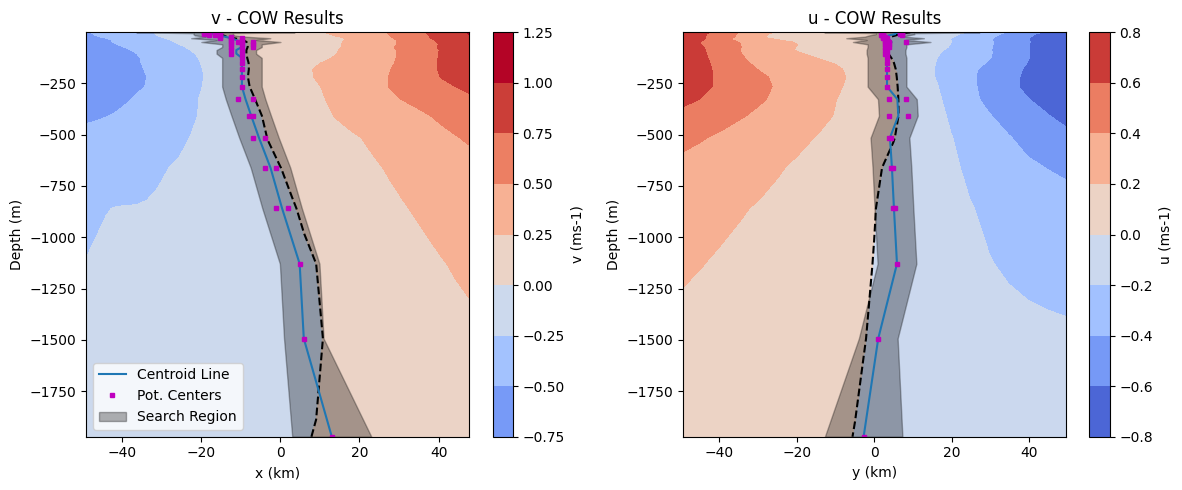

In [15]:
DISPLAY_WIDTH = 100000

i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, DISPLAY_WIDTH)
x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)
z = z_r[150, 150, :DEPTH_LVL_LIMIT]
xc_raw, yc_raw, zc, xp_raw, yp_raw, zp, radii = [], [], [], [], [], [], []
for depth_dic in depth_dics2.values():
    xc_raw.append(depth_dic['xc'])
    yc_raw.append(depth_dic['yc'])
    zc.append(depth_dic['Depth'])
    radii.append(depth_dic['Search Radius'])
    xp_raw.extend(depth_dic['df'].x)
    yp_raw.extend(depth_dic['df'].y)
    zp.extend([float(depth_dic['Depth'])]*len(depth_dic['df'].x))
zp = np.array(zp)
xc, yc = rotate_30_clockwise(xc_raw, yc_raw)
xp, yp = rotate_30_clockwise(xp_raw, yp_raw)
radii = np.array(radii)/1000

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
v_cross = V[i_left:i_right, j_search, :DEPTH_LVL_LIMIT, t_mod]
v_data_range = np.nanmax(np.abs(v_cross))
X, Z = np.meshgrid(x, z)
c1 = axs[0].contourf(X, Z, v_cross.T, cmap='coolwarm', vmin=-v_data_range, vmax=v_data_range)
c1_contour = axs[0].contour(X, Z, v_cross.T, levels=[0], colors='black', linestyles='--')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('v - COW Results')
c, = axs[0].plot(xc, zc, '-', linewidth=1.5)
m, = axs[0].plot(xp, zp, 's', markersize=3, color='m')
# axs[0].plot([xc-radii, xc+radii], [zc, zc], '-', linewidth=1, color='m')
sa = axs[0].fill_betweenx(zc, xc - radii, xc + radii, color='k', alpha=0.3)
axs[0].legend([c, m, sa, c1_contour], ['Centroid Line', 'Pot. Centers', 'Search Region'], loc='lower left')
fig.colorbar(c1, ax=axs[0], label='v (ms-1)')

# Second subplot
u_cross = U[i_search, j_down:j_up, :DEPTH_LVL_LIMIT, t_mod]
u_data_range = np.nanmax(np.abs(u_cross))
Y, Z = np.meshgrid(y, z)
c2 = axs[1].contourf(Y, Z, u_cross.T, cmap='coolwarm', vmin=-u_data_range, vmax=u_data_range)
c2_contour = axs[1].contour(Y, Z, u_cross.T, levels=[0], colors='black', linestyles='--')
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title('u - COW Results')
axs[1].plot(yc, zc, '-', linewidth=1.5)
axs[1].plot(yp, zp, 's', markersize=3, color='m')
# axs[1].plot([yc-radii, yc+radii], [zc, zc], '-', linewidth=1, color='m')
axs[1].fill_betweenx(zc, yc - radii, yc + radii, color='k', alpha=0.3)
fig.colorbar(c2, ax=axs[1], label='u (ms-1)')

plt.tight_layout()
plt.show()

## Non Pin Point Methods

### 3. Correlation Method

#### Choose DataField

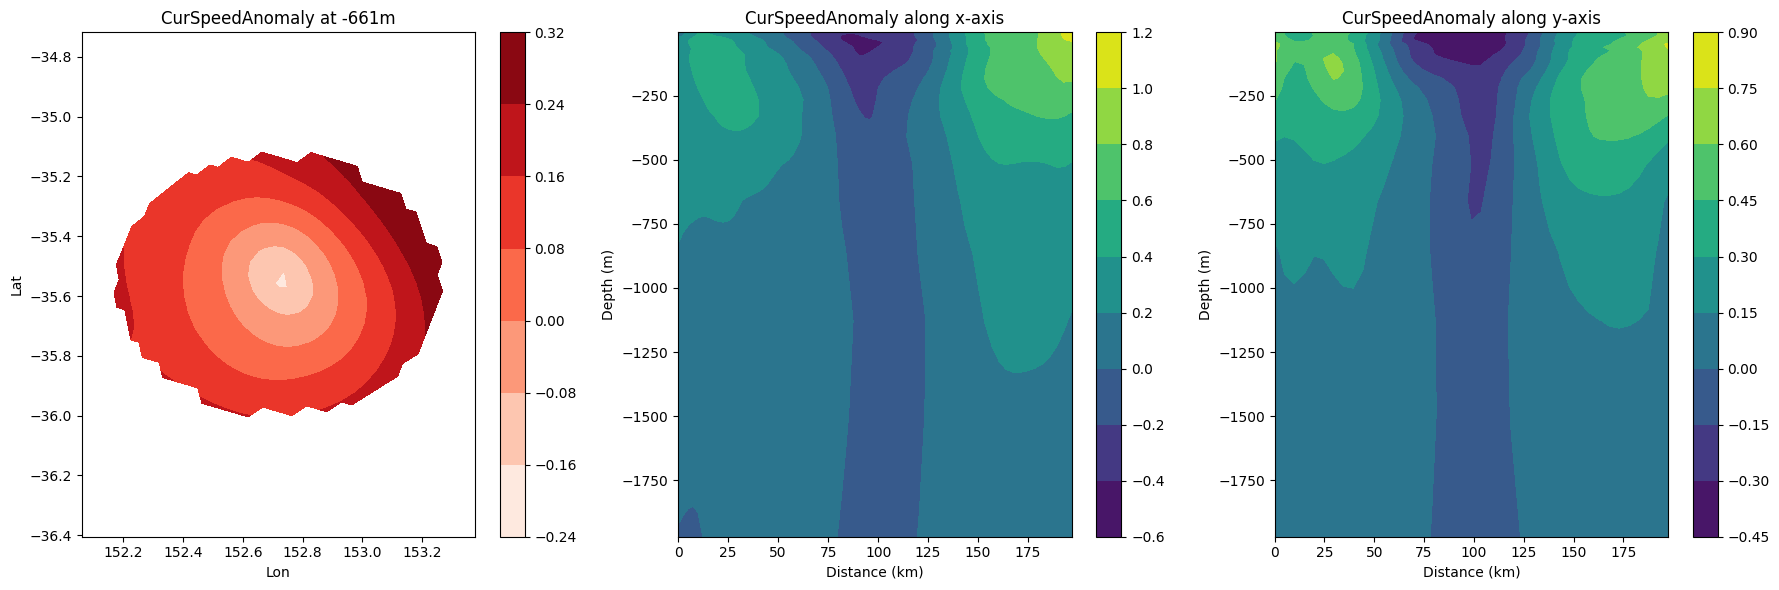

In [21]:
DataField3 = CurSpeedAnomaly

DataField3_name = get_variable_name(DataField3)
DataField3 = np.squeeze(DataField3[:, :, :, t_mod])

# Create a figure with 1x3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: 
DEPTH_LVL = 20
R = distance(edata.Lat, edata.Lon, lat_rho, lon_rho)
mask = R < 50000  # m
DataField3_masked = np.where(mask, DataField3[:, :, DEPTH_LVL], np.nan)
c1 = axs[0].contourf(lon_rho, lat_rho, DataField3_masked, cmap=colormap)
fig.colorbar(c1, ax=axs[0])
axs[0].set_xlabel('Lon')
axs[0].set_ylabel('Lat')
axs[0].set_title(DataField3_name + ' at ' + str(round(z_r[150, 150, DEPTH_LVL])) + 'm')
axs[0].axis('equal')
axs[0].set_xlim([np.nanmin(np.where(mask, lon_rho, np.nan)) - 0.05, np.nanmax(np.where(mask, lon_rho, np.nan)) + 0.05])
axs[0].set_ylim([np.nanmin(np.where(mask, lat_rho, np.nan)) - 0.05, np.nanmax(np.where(mask, lat_rho, np.nan)) + 0.05])

# Plot 2: DataField3 cross-section along x-axis
i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
SEARCH_WIDTH = 200000
depth_lvl_limit = 25
i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)
x = distance(lat_rho[i_left, j_search], lon_rho[i_left, j_search], lat_rho[i_left:i_right, j_search], lon_rho[i_left:i_right, j_search]) / 1000
y = distance(lat_rho[i_search, j_down], lon_rho[i_search, j_down], lat_rho[i_search, j_down:j_up], lon_rho[i_search, j_down:j_up]) / 1000
z = z_r[150, 150, :depth_lvl_limit]
DataField3_cross = DataField3[i_left:i_right, j_search, :depth_lvl_limit]
X, Z = np.meshgrid(x, z)
c2 = axs[1].contourf(X, Z, DataField3_cross.T)
fig.colorbar(c2, ax=axs[1])
axs[1].set_xlabel('Distance (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title(DataField3_name + ' along x-axis')

# Plot 3: DataField3 cross-section along y-axis
DataField3_cross = DataField3[i_search, j_down:j_up, :depth_lvl_limit]
Y, Z = np.meshgrid(y, z)
c3 = axs[2].contourf(Y, Z, DataField3_cross.T)
fig.colorbar(c3, ax=axs[2])
axs[2].set_xlabel('Distance (km)')
axs[2].set_ylabel('Depth (m)')
axs[2].set_title(DataField3_name + ' along y-axis')

plt.tight_layout()
plt.show()

#### Compute SSIM

In [22]:
from skimage.metrics import structural_similarity as ssim

def correlation_center_finder(grid1, grid2):
    def cycle_matrix(matrix, row_shift, col_shift):
        row_shift %= matrix.shape[0]
        col_shift %= matrix.shape[1]
        return np.roll(np.roll(matrix, row_shift, axis=0), col_shift, axis=1)

    def compare_matrices_ssim(matrix1, matrix2):
        data_range = matrix1.max() - matrix1.min()
        return ssim(matrix1, matrix2, data_range=data_range)

    def center_list(n):
        midpoint = n // 2
        return np.arange(-midpoint, n - midpoint)

    xs = center_list(grid1.shape[1])
    ys = center_list(grid1.shape[0])
    correlations = [
        (x, y, compare_matrices_ssim(grid1, cycle_matrix(grid2, y, x)))
        for x in xs for y in ys
    ]
    df = pd.DataFrame(correlations, columns=['Right', 'Up', 'Correlation'])
    best_shift = df.loc[df['Correlation'].idxmax()]

    return df, best_shift['Up'], best_shift['Right']

from shapely.geometry import Polygon
def calculate_centroid(xt, yt):
    if len(xt) == 0:
        return np.nan, np.nan
    polygon = Polygon(zip(xt, yt))
    centroid = polygon.centroid
    return centroid.x, centroid.y

In [29]:
SEARCH_WIDTH = 50000
DEPTH_LVL_LIMIT = 20
CORRELATION_THRESH = .7

ics, jcs = [], []
depth_dics3 = {}

clon, clat = edata.Lon, edata.Lat
for depth_lvl in range(DEPTH_LVL_LIMIT):
    i_search_lvl, j_search_lvl = eddies_nearest_rho(clon, clat)
    i_left, i_right, j_down, j_up = grid_finder(i_search_lvl, j_search_lvl, SEARCH_WIDTH)
    
    Data_abv = DataField3[i_left:i_right, j_down:j_up, depth_lvl]
    Data_blw = DataField3[i_left:i_right, j_down:j_up, depth_lvl + 1]

    df, iU, iR = correlation_center_finder(Data_abv, Data_blw)
    
    ic = int(iR + i_search_lvl)
    jc = int(iU + j_search_lvl)

    df['i'] = df.Right + i_search_lvl
    df['j'] = df.Up + j_search_lvl
    
    depth_dics3[f'Depth{depth_lvl}'] = {
        'df': df, 
        'ic': ic, 
        'jc': jc, 
        'Max Correlation': float(np.nanmax(df.Correlation)),
        'Depth': float(z_r[150, 150, depth_lvl])
    }

    ics.append(ic)
    jcs.append(jc)
    clon, clat = lon_rho[ic, jc], lat_rho[ic, jc]

i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
theta0, phi0 = np.deg2rad(edata.Lon), np.deg2rad(edata.Lat)

for depth_dic in depth_dics3.values():
    df = depth_dic['df']
    ix, jy = df.i, df.j
    ic, jc = depth_dic['ic'], depth_dic['jc']
    
    lons, lats = lon_rho[ix, jy], lat_rho[ix, jy]
    lonc, latc = lon_rho[ic, jc], lat_rho[ic, jc]

    x, y = make_cartesian(lons, lats, theta0, phi0)
    xc, yc = make_cartesian(lonc, latc, theta0, phi0)

    df['x'], df['y'] = x, y
    depth_dic['xc'], depth_dic['yc'] = float(xc), float(yc)

    xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)
    pi = griddata((x, y), df.Correlation, (xi, yi), method='cubic')
    
    fig, ax = plt.subplots()
    contour_set = ax.contour(xi, yi, pi, levels=[CORRELATION_THRESH])
    plt.close(fig)

    for path in contour_set.allsegs[0]:
        vertices = np.array(path)

    cnt_df = pd.DataFrame({'xt': vertices[:,0], 'yt': vertices[:,1]})
    
    depth_dic['Contour Paths'] = cnt_df
    depth_dic['xtc'], depth_dic['ytc'] = calculate_centroid(vertices[:,0], vertices[:,1])


#### Result

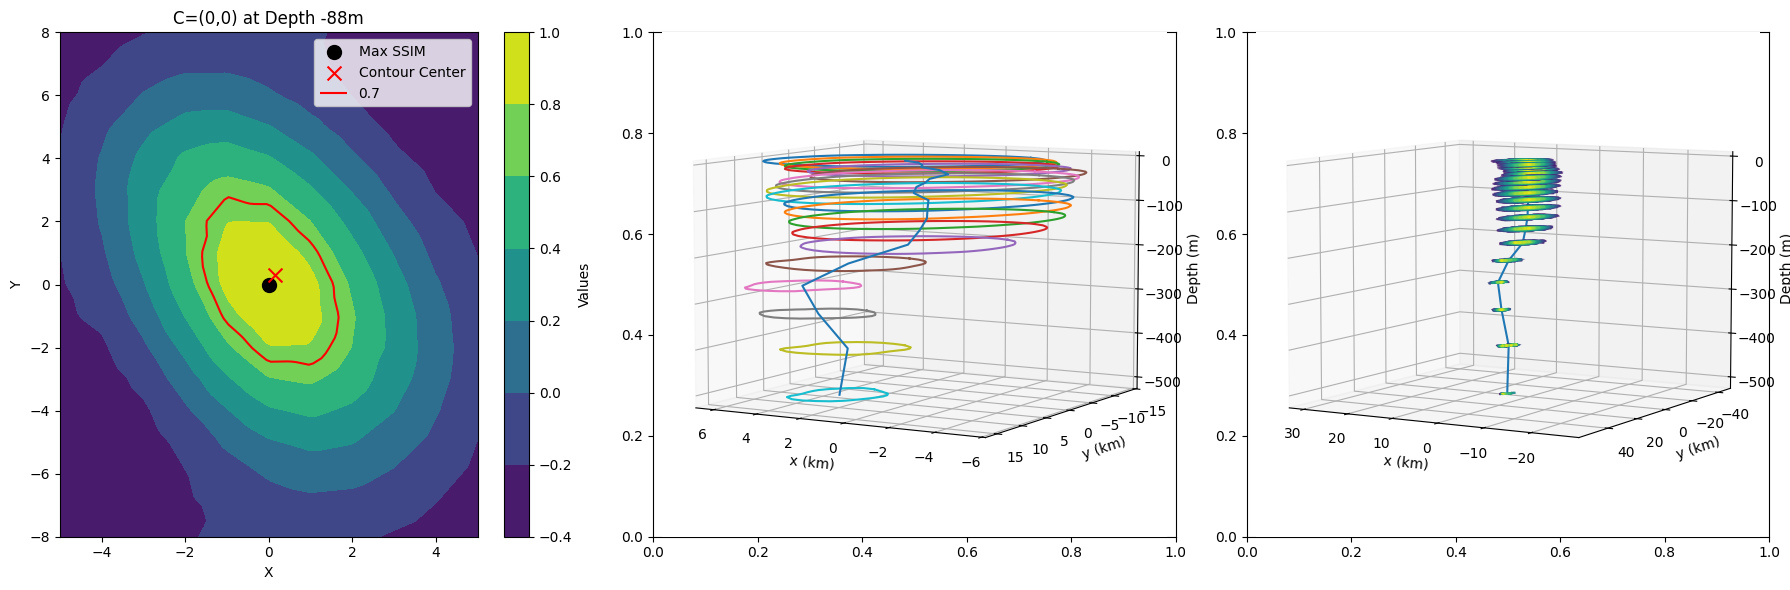

In [31]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 3 horizontal subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# PLOT1: 2D Contour Plot
depth_dic = depth_dics3['Depth10']
df = depth_dic['df']
xs, ys, values = df.Right, df.Up, df.Correlation
x, y, p = df.x, df.y, df.Correlation
d = depth_dic['Depth']
xc, yc = depth_dic['xc'], depth_dic['yc']
xtc, ytc = depth_dic['xtc'], depth_dic['ytc']
x_grid = np.linspace(xs.min(), xs.max(), 100)
y_grid = np.linspace(ys.min(), ys.max(), 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z = griddata((xs, ys), values, (X, Y), method='linear')
pcm = axs[0].contourf(X, Y, Z, cmap='viridis')
contour1 = axs[0].contour(X, Y, Z, levels=[CORRELATION_THRESH], colors='red', linestyles='-')
c = axs[0].scatter(xs[np.argmax(values)], ys[np.argmax(values)], color='black', s=100)
ct = axs[0].scatter(xtc, ytc, color='r', marker='x', s=100)  # Highlight max value
# Add colorbar to PLOT1
cbar = fig.colorbar(pcm, ax=axs[0], orientation='vertical')
cbar.set_label('Values')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_title(f'C=({xs[np.argmax(values)]},{ys[np.argmax(values)]}) at Depth {round(d)}m')
h, _ = contour1.legend_elements()
axs[0].legend([c, ct, h[0]], ['Max SSIM', 'Contour Center',f'{CORRELATION_THRESH}'])

# PLOT2: 3D Contour Paths
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
xtcs, ytcs, ztcs = [], [], []
for depth_dic in depth_dics3.values():
    depth = depth_dic['Depth']
    ax2.plot(depth_dic['Contour Paths'].xt, depth_dic['Contour Paths'].yt, [depth] * len(depth_dic['Contour Paths'].xt))
    xtc, ytc, ztc = depth_dic['xtc'], depth_dic['ytc'], depth
    xtcs.append(xtc)
    ytcs.append(ytc)
    ztcs.append(ztc)
ax2.plot(xtcs, ytcs, ztcs)
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')
ax2.set_zlabel('Depth (m)')
ax2.view_init(elev=7, azim=120)

# PLOT3: 3D Surface Plot
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
for depth_dic in depth_dics3.values():
    x, y, values = depth_dic['df'].x, depth_dic['df'].y, depth_dic['df'].Correlation
    depth = depth_dic['Depth']
    X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
    Z = griddata((x, y), values, (X, Y), method='linear')
    Z_filtered = np.where(Z > CORRELATION_THRESH, Z, np.nan)
    # ax3.plot_surface(X, Y, Z_filtered + depth, cmap='viridis', edgecolor='none', alpha=0.7)
    ax3.contour3D(X, Y, Z_filtered + depth, 50, cmap='viridis', alpha=0.5)
ax3.plot(xtcs, ytcs, ztcs)
ax3.set_xlabel('x (km)')
ax3.set_ylabel('y (km)')
ax3.set_zlabel('Depth (m)')
ax3.view_init(elev=7, azim=120)

# Adjust layout to make space for labels
plt.tight_layout()
plt.show()


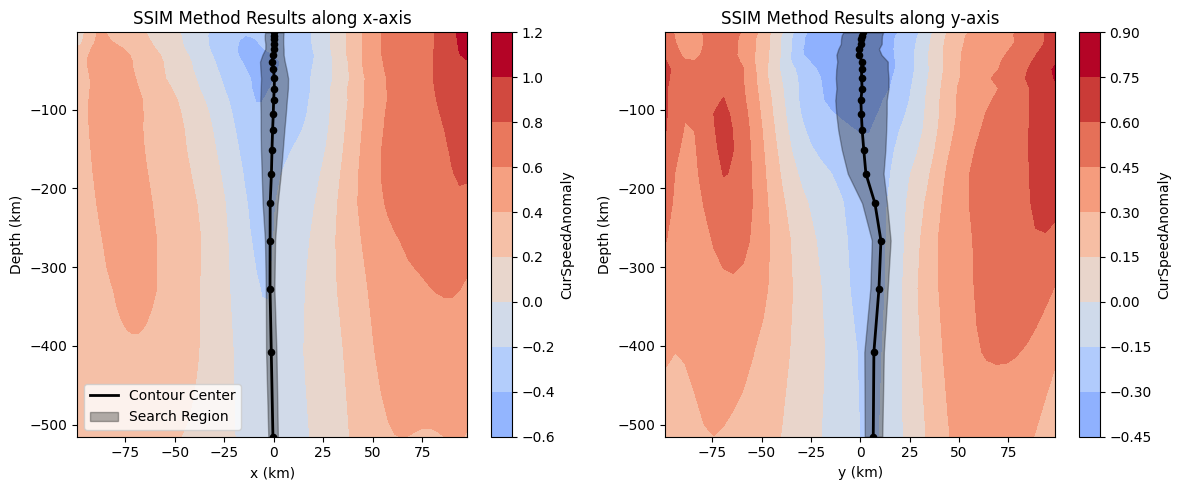

In [32]:
import matplotlib.colors as mcolors

DISPLAY_WIDTH = 200000

i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, DISPLAY_WIDTH)
x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)
xc_raw, yc_raw, zc, xt_mins, xt_maxs, yt_mins, yt_maxs = [], [], [], [], [], [], []
for depth_dic in depth_dics3.values():
    xc_raw.append(depth_dic['xtc'])
    yc_raw.append(depth_dic['ytc'])
    zc.append(depth_dic['Depth'])

    xt, yt = rotate_30_clockwise(depth_dic['Contour Paths'].xt, depth_dic['Contour Paths'].yt)
    xt_mins.append(np.min(xt))
    xt_maxs.append(np.max(xt))
    yt_mins.append(np.min(yt))
    yt_maxs.append(np.max(yt))

xc, yc = rotate_30_clockwise(xc_raw, yc_raw)
z = z_r[150, 150, :DEPTH_LVL_LIMIT]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
DataField3_cross = DataField3[i_left:i_right, j_search, :DEPTH_LVL_LIMIT]
X, Z = np.meshgrid(x, z)
DataField3_data_range = np.nanmax(np.abs(DataField3_cross))
c1 = axs[0].contourf(X, Z, DataField3_cross.T, cmap='coolwarm', vmin=-DataField3_data_range, vmax=DataField3_data_range)
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (km)')
axs[0].set_title('SSIM Method Results along x-axis')
fig.colorbar(c1, ax=axs[0], label=DataField3_name)
axs[0].scatter(xc, zc, color='k', s=20)
c, = axs[0].plot(xc, zc, color='k', linewidth=2)
sa = axs[0].fill_betweenx(zc, xt_mins, xt_maxs, color='k', alpha=0.3)
axs[0].legend([c, sa], ['Contour Center', 'Search Region'], loc='lower left')

# Second subplot
DataField3_cross = DataField3[i_search, j_down:j_up, :DEPTH_LVL_LIMIT] 
Y, Z = np.meshgrid(y, z)
DataField3_data_range = np.nanmax(np.abs(DataField3_cross))
c2 = axs[1].contourf(Y, Z, DataField3_cross.T, cmap='coolwarm', vmin=-DataField3_data_range, vmax=DataField3_data_range)
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (km)')
axs[1].set_title('SSIM Method Results along y-axis')
fig.colorbar(c2, ax=axs[1], label=DataField3_name)
axs[1].scatter(yc, zc, color='k', s=20)
axs[1].plot(yc, zc, color='k', linewidth=2)
axs[1].fill_betweenx(zc, yt_mins, yt_maxs, color='k', alpha=0.3)

plt.tight_layout()
plt.show()

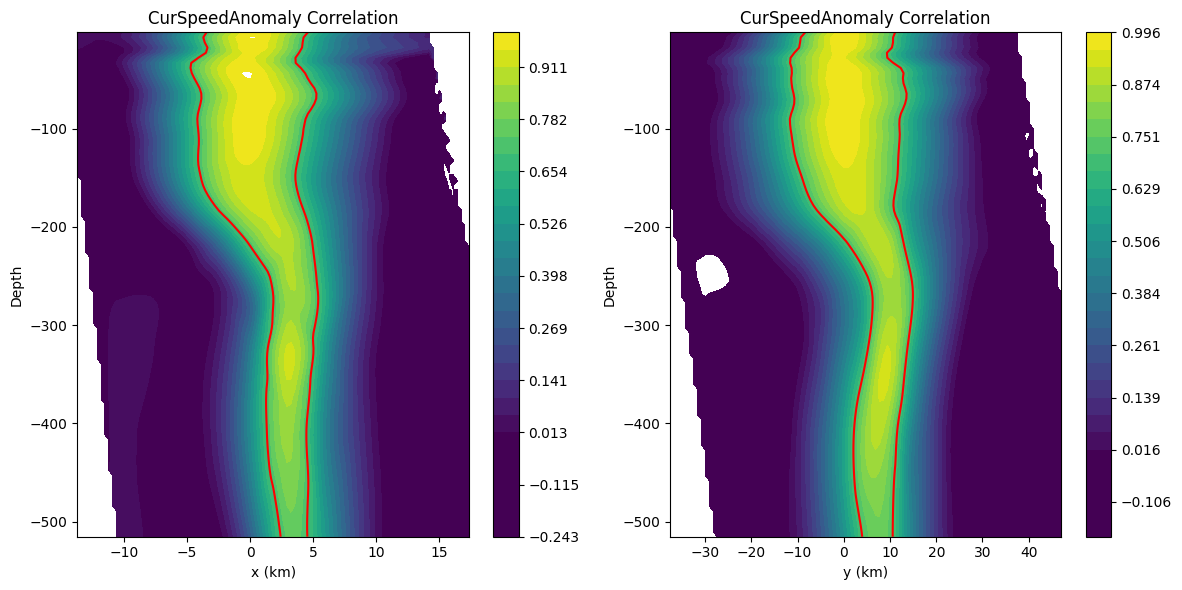

In [33]:
from scipy.interpolate import griddata

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Data preparation for x vs Depth plot
xs, ds, ps = [], [], []
for depth_dic in depth_dics3.values():
    x = depth_dic['df']['x']
    d = [depth_dic['Depth']] * len(x)
    p = depth_dic['df']['Correlation']
    j = depth_dic['df']['j']
    jc = depth_dic['jc']
    col_idx = j == jc
    x = [x[i] for i in range(len(x)) if col_idx[i]]
    d = [d[i] for i in range(len(d)) if col_idx[i]]
    p = [p[i] for i in range(len(p)) if col_idx[i]]
    xs.extend(x)
    ds.extend(d)
    ps.extend(p)
x, y, p = xs, ds, ps
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)
pi = griddata((x, y), p, (xi, yi), method='cubic')
levels = np.linspace(min(p), max(p), 30)
contourf = axs[0].contourf(xi, yi, pi, levels=levels, cmap='viridis', vmin=0, vmax=1)
contour = axs[0].contour(xi, yi, pi, levels=[CORRELATION_THRESH], colors='red')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth')
axs[0].set_title(DataField3_name+' Correlation')
plt.colorbar(contourf, ax=axs[0])

# Data preparation for y vs Depth plot
ys, ds, ps = [], [], []
for depth_dic in depth_dics3.values():
    y = depth_dic['df']['y']
    d = [depth_dic['Depth']] * len(y)
    p = depth_dic['df']['Correlation']
    i = depth_dic['df']['i']
    ic = depth_dic['ic']
    row_idx = i == ic
    y = [y[i] for i in range(len(y)) if row_idx[i]]
    d = [d[i] for i in range(len(d)) if row_idx[i]]
    p = [p[i] for i in range(len(p)) if row_idx[i]]
    ys.extend(y)
    ds.extend(d)
    ps.extend(p)
x, y, p = ys, ds, ps
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)
pi = griddata((x, y), p, (xi, yi), method='cubic')
levels = np.linspace(min(p), max(p), 30)
contourf = axs[1].contourf(xi, yi, pi, levels=levels, cmap='viridis', vmin=0, vmax=1)
contour = axs[1].contour(xi, yi, pi, levels=[CORRELATION_THRESH], colors='red')
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth')
axs[1].set_title(DataField3_name+' Correlation')
plt.colorbar(contourf, ax=axs[1])

plt.tight_layout()
plt.show()


### 4. Closed Convex Contour Method

#### Choose DataField

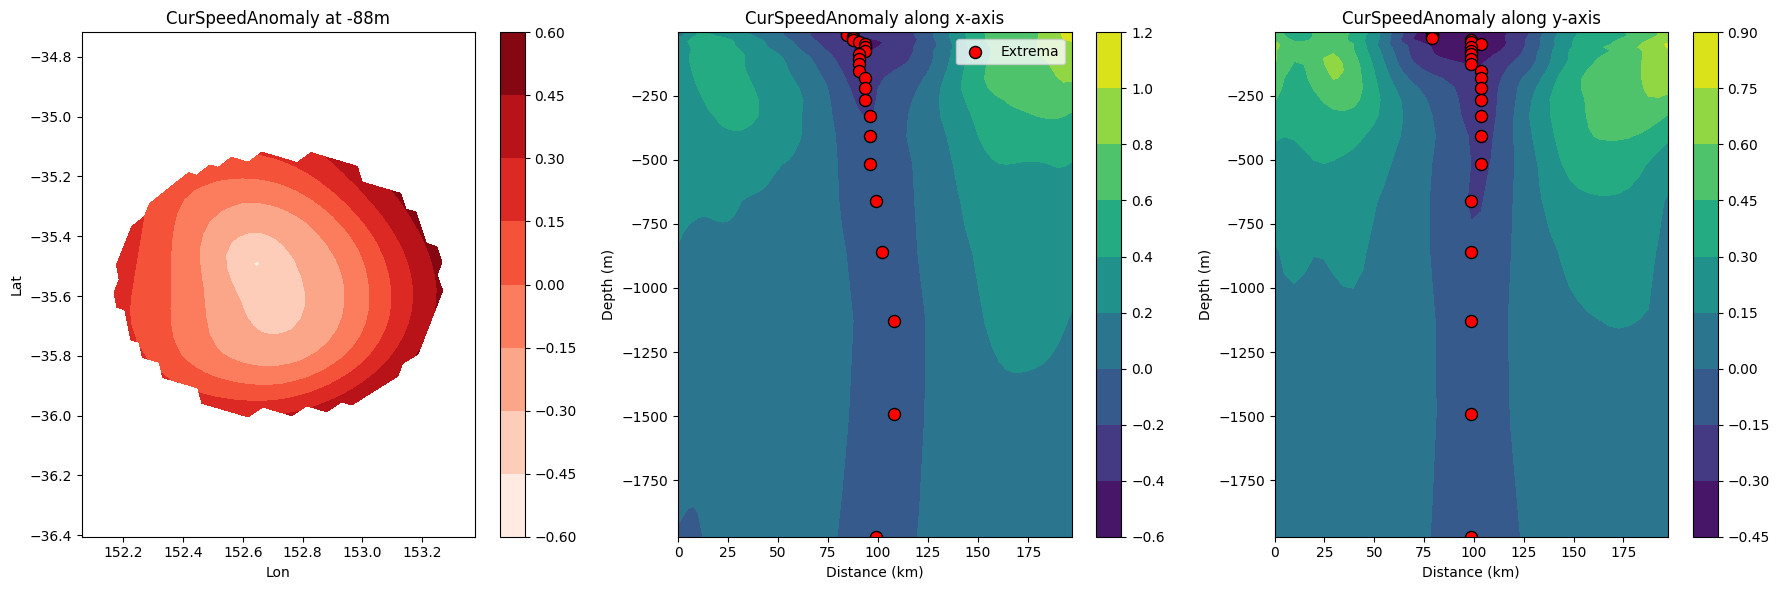

In [106]:
DataField4 = CurSpeedAnomaly

DataField4_name = get_variable_name(DataField4)
DataField4 = np.squeeze(DataField4[:, :, :, t_mod])

# Create a figure with 1x3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

SEARCH_WIDTH = 200000
DEPTH_LVL_LIMIT = 25
i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)
x = distance(lat_rho[i_left, j_search], lon_rho[i_left, j_search], lat_rho[i_left:i_right, j_search], lon_rho[i_left:i_right, j_search]) / 1000
y = distance(lat_rho[i_search, j_down], lon_rho[i_search, j_down], lat_rho[i_search, j_down:j_up], lon_rho[i_search, j_down:j_up]) / 1000
z = z_r[150, 150, :DEPTH_LVL_LIMIT]

# Plot 1: 
DEPTH_LVL = 10
R = distance(edata.Lat, edata.Lon, lat_rho, lon_rho)
mask = R < 50000  # m
DataField4_masked = np.where(mask, DataField4[:, :, DEPTH_LVL], np.nan)
c1 = axs[0].contourf(lon_rho, lat_rho, DataField4_masked, cmap=colormap)
fig.colorbar(c1, ax=axs[0])
axs[0].set_xlabel('Lon')
axs[0].set_ylabel('Lat')
axs[0].set_title(DataField4_name + ' at ' + str(round(z_r[150, 150, DEPTH_LVL])) + 'm')
axs[0].axis('equal')
axs[0].set_xlim([np.nanmin(np.where(mask, lon_rho, np.nan)) - 0.05, np.nanmax(np.where(mask, lon_rho, np.nan)) + 0.05])
axs[0].set_ylim([np.nanmin(np.where(mask, lat_rho, np.nan)) - 0.05, np.nanmax(np.where(mask, lat_rho, np.nan)) + 0.05])

# Plot 2: DataField4 cross-section along x-axis
DataField4_cross = DataField4[i_left:i_right, j_search, :DEPTH_LVL_LIMIT]
X, Z = np.meshgrid(x, z)
c2 = axs[1].contourf(X, Z, DataField4_cross.T)
fig.colorbar(c2, ax=axs[1])
axs[1].set_xlabel('Distance (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title(DataField4_name + ' along x-axis')
if DataField4_name == 'CurSpeedAnomaly':
    max_indices = np.nanargmin(DataField4_cross, axis=0)
else:
    max_indices = np.nanargmax(DataField4_cross, axis=0) if edata.Vort > 0 else np.nanargmin(DataField4_cross, axis=0)
for r, max_index in enumerate(max_indices):
    m1 = axs[1].scatter(x[max_index], z[r], color=mcolor, edgecolor='k', s=75)
axs[1].legend([m1], ['Extrema'])

# Plot 3: DataField4 cross-section along y-axis
DataField4_cross = DataField4[i_search, j_down:j_up, :DEPTH_LVL_LIMIT]
Y, Z = np.meshgrid(y, z)
c3 = axs[2].contourf(Y, Z, DataField4_cross.T)
fig.colorbar(c3, ax=axs[2])
axs[2].set_xlabel('Distance (km)')
axs[2].set_ylabel('Depth (m)')
axs[2].set_title(DataField4_name + ' along y-axis')
if DataField4_name == 'CurSpeedAnomaly':
    max_indices = np.nanargmin(DataField4_cross, axis=0)
else:
    max_indices = np.nanargmax(DataField4_cross, axis=0) if edata.Vort > 0 else np.nanargmin(DataField4_cross, axis=0)
for r, max_index in enumerate(max_indices):
    axs[2].scatter(y[max_index], z[r], color=mcolor, edgecolor='k', s=75)

plt.tight_layout()
plt.show()

#### Compute Contours

In [46]:
def matrix_range(matrix):
    return np.nanmax(matrix) - np.nanmin(matrix)

from scipy.spatial import ConvexHull
from shapely.geometry import Point, Polygon
def IsContourConvex(xt, yt, DeficiencyThresh):
    points = list(zip(xt, yt))
    hull = ConvexHull(points, qhull_options='QJ')
    HullArea = hull.volume  # In 2D, volume is the area
    polygon = Polygon(points)
    Area = polygon.area
    if Area == 0:
        return False
    AreaDeficiency = abs(HullArea - Area) / Area * 100
    return AreaDeficiency <= DeficiencyThresh

def IsContourClosed(xt, yt, tolerance=1e-6):
    return len(xt) > 0 and len(yt) > 0 and (abs(xt[0] - xt[-1]) < tolerance) and (abs(yt[0] - yt[-1]) < tolerance)

def is_point_inside_contour(x_coords, y_coords, px, py):
    contour = Polygon(zip(x_coords, y_coords))
    point = Point(px, py)
    return contour.contains(point)

def find_global_maxima(matrix):
    i_max, j_max = np.unravel_index(np.argmax(matrix, axis=None), matrix.shape)
    return i_max, j_max

def max_closed_convex_contour_finder(xc_max, yc_max, x, y, DF, num_contours):

    X, Y = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
    Z = griddata((x, y), DF, (X, Y), method='linear')
    
    data_range = matrix_range(Z)
    largest_contour_xt, largest_contour_yt = [], []
    for k in range(1, num_contours + 1):

        level_to_extract = np.nanmax(Z) - k * data_range / num_contours
        fig, ax = plt.subplots()
        c = ax.contour(X, Y, Z, levels=[level_to_extract], linewidths=1, colors='k')
        for level_paths in c.allsegs:
            for path in level_paths:
                xt = path[:, 0]
                yt = path[:, 1]
        plt.close(fig)
        if IsContourClosed(xt, yt):
            if IsContourConvex(xt, yt, DeficiencyThresh=10):
                if is_point_inside_contour(xt, yt, xc_max, yc_max):
                    if len(xt) > len(largest_contour_xt):
                        largest_contour_xt, largest_contour_yt = xt, yt
    df = pd.DataFrame({'xt': largest_contour_xt, 'yt': largest_contour_yt})
    return df

In [74]:
SEARCH_RADIUS = 50000
DEPTH_LVL_LIMIT = 25

depth_dics4 = {}

clon, clat = edata.Lon, edata.Lat
for depth_lvl in range(DEPTH_LVL_LIMIT):
    i_search_lvl, j_search_lvl = eddies_nearest_rho(clon, clat)
    R = distance(lat_rho[i_search_lvl, j_search_lvl], lon_rho[i_search_lvl, j_search_lvl], lat_rho, lon_rho)
    mask = R < SEARCH_RADIUS
    
    DataField4_masked = np.where(mask, DataField4[:,:,depth_lvl], np.nan) 
    if np.any(np.isfinite(DataField4_masked)):
        if DataField4_name == 'CurSpeedAnomaly':
            ic, jc = np.unravel_index(np.nanargmin(DataField4_masked), DataField4_masked.shape)
        else:
            if edata.Vort > 0:
                ic, jc = np.unravel_index(np.nanargmax(DataField4_masked), DataField4_masked.shape)
            elif edata.Vort < 0:
                ic, jc = np.unravel_index(np.nanargmin(DataField4_masked), DataField4_masked.shape)
        ic, jc = int(ic), int(jc)
    
        ix, jy = np.where(mask == True)
        df = pd.DataFrame({
            'i': ix,
            'j': jy,
            'DataField': DataField4_masked[ix,jy]
        })
    
        depth = float(z_r[150,150,depth_lvl])
    
        depth_dics4['Depth'+str(depth_lvl)] = {'df': df, 'ic': ic, 'jc': jc, 'Depth': depth}
    
        clon, clat = lon_rho[ic, jc], lat_rho[ic, jc]

# Calculate Cartesian Grid
theta0, phi0 = np.deg2rad(edata.Lon), np.deg2rad(edata.Lat)
for depth_dic in depth_dics4.values():
    
    ix = depth_dic['df'].i
    jy = depth_dic['df'].j
    ic = depth_dic['ic']
    jc = depth_dic['jc']
    
    lons, lats = lon_rho[ix, jy], lat_rho[ix, jy]
    lonc, latc = lon_rho[ic, jc], lat_rho[ic, jc]

    x, y = make_cartesian(lons, lats, theta0, phi0)
    xc, yc = make_cartesian(lonc, latc, theta0, phi0)

    depth_dic['df']['x'] = x
    depth_dic['df']['y'] = y
    depth_dic['xc'] = float(xc)
    depth_dic['yc'] = float(yc)


for depth_dic in depth_dics4.values():
    DF = depth_dic['df']['DataField']
    x = depth_dic['df'].x
    y = depth_dic['df'].y
    xc = depth_dic['xc']
    yc = depth_dic['yc']
    depth_dic['Contour'] = max_closed_convex_contour_finder(xc, yc, x, y, DF, num_contours=100)
    xtc, ytc = calculate_centroid(depth_dic['Contour'].xt, depth_dic['Contour'].yt)
    depth_dic['xtc'] = xtc
    depth_dic['ytc'] = ytc

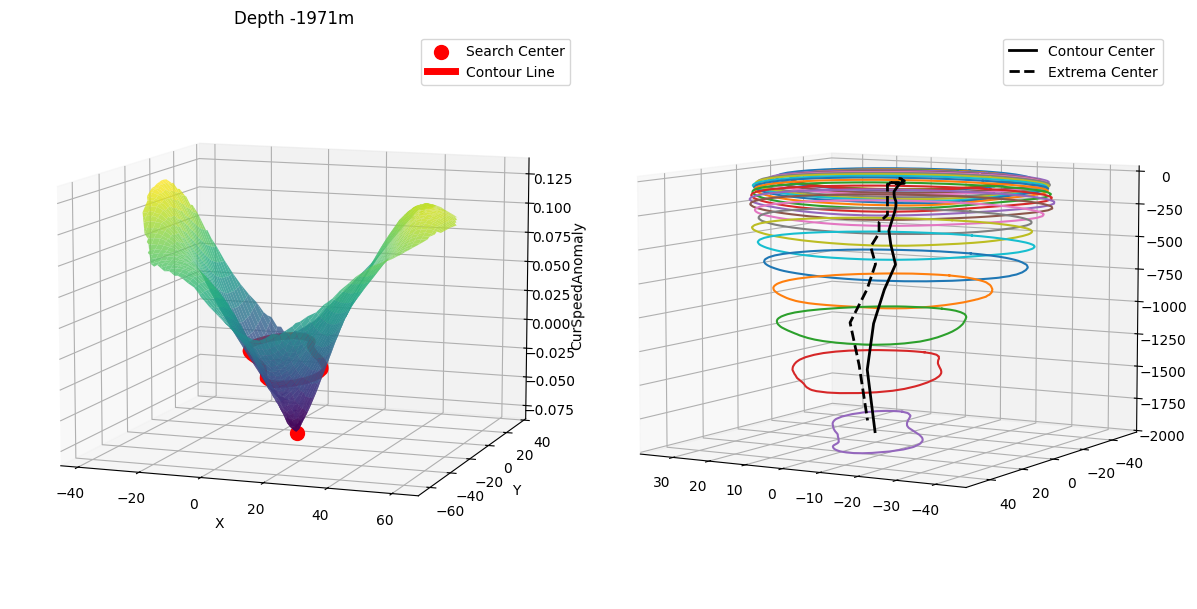

In [104]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np

depth_dic = depth_dics4['Depth24']

x = depth_dic['df'].x
y = depth_dic['df'].y
z = depth_dic['Depth']
DF = depth_dic['df']['DataField']
xc = depth_dic['xc']
yc = depth_dic['yc']
xt = depth_dic['Contour'].xt
yt = depth_dic['Contour'].yt

X, Y = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
Z = griddata((x, y), DF, (X, Y), method='linear')

fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 6))

# First plot
axs[0].plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
zc = griddata((x, y), DF, (xc, yc), method='linear')
axs[0].scatter(xc, yc, zc, color='red', s=100, label='Search Center')
zt = griddata((x, y), DF, (xt, yt), method='linear')
axs[0].plot(xt, yt, zt, color='r', linewidth=5, label='Contour Line')
axs[0].view_init(elev=10, azim=290)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_zlabel(DataField4_name)
axs[0].legend()
axs[0].set_title('Depth '+str(round(z))+'m')

# Second plot
xtc, ytc, xc, yc, z = [], [], [], [], []
for depth_dic in depth_dics4.values():
    xtc.append(depth_dic['xtc'])
    ytc.append(depth_dic['ytc'])
    xc.append(depth_dic['xc'])
    yc.append(depth_dic['yc'])
    xt = depth_dic['Contour'].xt
    yt = depth_dic['Contour'].yt
    zt = [depth_dic['Depth']] * len(xt)
    z.append(depth_dic['Depth'])
    axs[1].plot(xt, yt, zt)
a, = axs[1].plot(xtc, ytc, z, color='k', linewidth=2)
b, = axs[1].plot(xc, yc, z, color='k', linestyle='--', linewidth=2)
axs[1].legend([a, b], ['Contour Center', 'Extrema Center'])
axs[1].view_init(elev=7, azim=120)

plt.tight_layout()
plt.show()


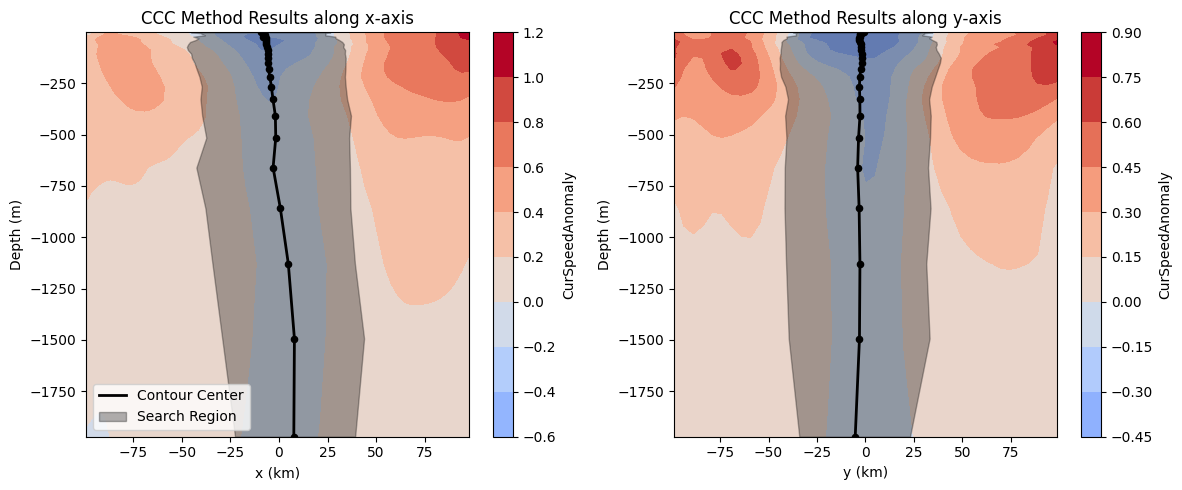

In [107]:
import matplotlib.colors as mcolors

DISPLAY_WIDTH = 200000

i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, DISPLAY_WIDTH)
x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)
xc_raw, yc_raw, zc, xt_mins, xt_maxs, yt_mins, yt_maxs, zt = [], [], [], [], [], [], [], []
for depth_dic in depth_dics4.values():
    if ~np.isnan(depth_dic['xtc']):
        xc_raw.append(depth_dic['xtc'])
        yc_raw.append(depth_dic['ytc'])
        zc.append(depth_dic['Depth'])

    xt, yt = rotate_30_clockwise(depth_dic['Contour'].xt, depth_dic['Contour'].yt)
    if len(xt) > 0:
        xt_mins.append(np.min(xt))
        xt_maxs.append(np.max(xt))
        yt_mins.append(np.min(yt))
        yt_maxs.append(np.max(yt))
        zt.append(depth_dic['Depth'])

xc, yc = rotate_30_clockwise(xc_raw, yc_raw)
z = z_r[150, 150, :DEPTH_LVL_LIMIT]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
DataField4_cross = DataField4[i_left:i_right, j_search, :DEPTH_LVL_LIMIT]
X, Z = np.meshgrid(x, z)
DataField4_data_range = np.nanmax(np.abs(DataField4_cross))
c1 = axs[0].contourf(X, Z, DataField4_cross.T, cmap='coolwarm', vmin=-DataField4_data_range, vmax=DataField4_data_range)
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('CCC Method Results along x-axis')
fig.colorbar(c1, ax=axs[0], label=DataField4_name)
axs[0].scatter(xc, zc, color='k', s=20)
c, = axs[0].plot(xc, zc, color='k', linewidth=2)
sa = axs[0].fill_betweenx(zt, xt_mins, xt_maxs, color='k', alpha=0.3)
axs[0].legend([c, sa], ['Contour Center', 'Search Region'], loc='lower left')

# Second subplot
DataField4_cross = DataField4[i_search, j_down:j_up, :DEPTH_LVL_LIMIT] 
Y, Z = np.meshgrid(y, z)
DataField4_data_range = np.nanmax(np.abs(DataField4_cross))
c2 = axs[1].contourf(Y, Z, DataField4_cross.T, cmap='coolwarm', vmin=-DataField4_data_range, vmax=DataField4_data_range)
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title('CCC Method Results along y-axis')
fig.colorbar(c2, ax=axs[1], label=DataField4_name)
axs[1].scatter(yc, zc, color='k', s=20)
axs[1].plot(yc, zc, color='k', linewidth=2)
axs[1].fill_betweenx(zt, yt_mins, yt_maxs, color='k', alpha=0.3)

plt.tight_layout()
plt.show()